# **Model Tuning**



# Mô hình: Gradient Boosting Machine 


## Ensemble Methods

Ensemble Methods (Học kết hợp) là phương pháp giải quyết bài toán bằng cách xây dựng nhiều mô hình "yếu“ (weak learner), đơn giản và kết hợp chúng là với nhau để thu được một mô hình vượt trội, thay vì xây dựng một mô hình thật sự tốt ngay từ ban đầu.

## Boosting

Là một trong 3 nhóm của Ensemble Methods (bên cạnh Bagging và Stacking).

Boosting là một phương pháp xây dựng một loạt các mô hình giống nhau, trong đó các mô hình sau sẽ cố gắng học để hạn chế lỗi của mô hình trước. Mỗi mô hình có thể xem là một base model hay weak learner.

Có 2 loại Boosting là:
- Adaptive Boosting (AdaBoost)
- Gradient Boosting

## Gradient Boosting

Gradient Boosting là một phương pháp xây dựng một loạt các mô hình giống nhau, trong đó các mô hình sau sẽ cố gắng học để hạn chế lỗi của mô hình trước. Thuật toán dựa vào Gradient Descent và ở đây mỗi base model là một cây quyết định. Mỗi mô hình thường là một cây quyết định.

Có 2 framework phổ biến nhất là XGBoost và LightGBM.

### Lý do lựa chọn LightGBM

- Đây là một trong những thuật toán mạnh nhất hiện nay.
- Có thể xử lý vấn đề missing value, có feature important để loại bớt các thuộc tính không cần thiết.
- Nó có tốc độ xử lý nhanh hơn rất nhiều lần so với XGBoost. (Vì XGBoost chạy rất chậm với tập dữ liệu lớn).

LightGBM sử dụng phương pháp leaf - wise:

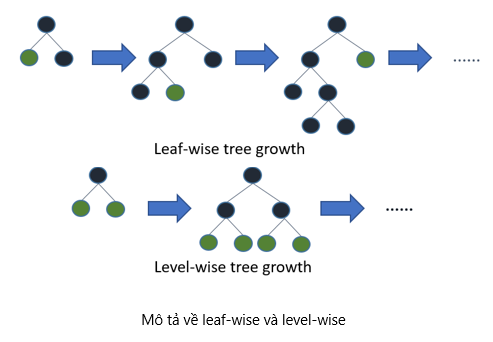

# Hyperparameter Tuning



Điều chỉnh siêu tham số (Hyperparameter Tuning) là quá trình điều chỉnh mô hình và tìm sự kết hợp của các giá trị siêu tham số cho một mô hình học máy để đạt được độ đo tốt nhất cho một vấn đề.

Có một số cách thường thấy của việc điều chỉnh siêu tham số:

1. __Thủ công__: lựa chọn siêu tham số dựa vào kinh nghiệm, suy đoán... và sau đó huấn luyện mô hình. Lặp lại các bước khi được kết quả phù hợp hoặc khi hết kiên nhẫn.
2. __Grid Search__: tạo một lưới các giá trị siêu tham số và huấn luyện mô hình, tính số điểm trên tập validation với mỗi sự kết hợp.
3. __Random search__: tạo một lưới các giá trị siêu tham số và lựa chọn ngẫu nhiên một số sự kết hợp để huấn luyện và tính điểm của mô hình. Số lần lặp lại dựa trên tài nguyên/thời gian.
4. __Automated Hyperparameter Tuning__: sử dụng các phương pháp như gradient descent, Bayesian Optiomization hoặc các thuật toán cải tiến để tìm kiếm các siêu tham số tốt nhất.

(Ta có thể xem chi tiết hơn [tại đây](https://en.wikipedia.org/wiki/Hyperparameter_optimization))

Ở Notebook này để cập đến cách tiếp cận 2 và 3.

### Ví dụ:

A = { True, False }

B = { 1, 2, 3 }

Grid Search: duyệt lần lượt tất cả các trường hợp: (True,1), (True,2), (True, 3), (False,1), (False,2), (False,3).

Random Search: với n = 3, duyệt ngẫu nhiên 3 kết hợp ở trên.

## Import Thư viện

In [ ]:
# Data manipulation
import pandas as pd
import numpy as np

# Modeling
import lightgbm as lgb

# Splitting data
from sklearn.model_selection import train_test_split

N_FOLDS = 5
MAX_EVALS = 5

## Import Data

Chọn ra 16000 mẫu, trong đó 10000 mẫu dùng để train và 6000 mẫu dùng để test.

In [ ]:
features = pd.read_csv('../input/home-credit-default-risk/application_train.csv')

# Sample 16000 rows (10000 for training, 6000 for testing)
features = features.sample(n = 16000, random_state = 42)

# Only numeric features
features = features.select_dtypes('number')

# Extract the labels
labels = np.array(features['TARGET'].astype(np.int32)).reshape((-1, ))
features = features.drop(columns = ['TARGET', 'SK_ID_CURR'])

# Split into training and testing data
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 6000, random_state = 50)

Sử dụng các đặc trưng là số để giảm kích thước và giúp tăng tốc độ tìm kiếm siêu tham số.

In [ ]:
print("Training features shape: ", train_features.shape)
print("Testing features shape: ", test_features.shape)

Training features shape:  (10000, 104)
Testing features shape:  (6000, 104)


## Một số phương pháp được áp dụng

### Cross Validation

Chia tập train thành các tập con nhỏ đến tiến hành huấn luyện và xác thực chéo lẫn nhau. Sử dụng 5 lần xác thực chéo KFold (KFold cross validation). Hiệu suất của mỗi bộ siêu tham số sẽ được tính bằng ROC AUC.



### Early Stopping

Siêu tham số number of estimators (số lượng cây quyết định được đào tạo tuần tự) là một trong những siêu tham số quan trọng nhất trong GBM. Phương pháp early stopping sẽ dừng quá trình train khi lỗi không giảm trong một số lần lặp nhất định. Trong bài này, tác giả áp dụng early stopping với 100 lần lặp. 

Nếu ta cứ tiếp tục huấn luyện khi độ lỗi không giảm thì có thể sai số huấn luyện sẽ giảm nhưng sẽ dẫn đến việc overfitting do mô hình quá phụ thuộc vào dữ liệu train.

### Ví dụ

In [ ]:
# Create a training and testing dataset
train_set = lgb.Dataset(data = train_features, label = train_labels)
test_set = lgb.Dataset(data = test_features, label = test_labels)

Thực hiện đồng thời cross validation 5 folds và early stopping với 100 vòng. Số vòng lặp truyền vào là 10000 vòng.
The code below carries out both cross validation with 5 folds and early stopping with 100 early stopping rounds. 

In [ ]:
# Get default hyperparameters
model = lgb.LGBMClassifier()
default_params = model.get_params()

# Remove the number of estimators because we set this to 10000 in the cv call
del default_params['n_estimators']

# Cross validation with early stopping, num_boost_round: number of boosting iterations
cv_results = lgb.cv(default_params, train_set, num_boost_round = 10000, early_stopping_rounds = 100, 
                    metrics = 'auc', nfold = N_FOLDS, seed = 42)

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:661: UserWarning: silent keyword has been found in `params` and will be ignored. Please use silent argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


cv_result sẽ là một danh sách các giá trị trung bình và độ lệch chuẩn của "metric". Giá trị cuối (index = -1) sẽ thể hiện hiệu suất tốt nhất. Kích thước của danh sách sẽ là số vòng lặp tối ưu để huấn luyện.

In [ ]:
print('The maximum validation ROC AUC was: {:.5f} with a standard deviation of {:.5f}.'.format(cv_results['auc-mean'][-1], cv_results['auc-stdv'][-1]))
print('The optimal number of boosting rounds (estimators) was {}.'.format(len(cv_results['auc-mean'])))

The maximum validation ROC AUC was: 0.70147 with a standard deviation of 0.01872.
The optimal number of boosting rounds (estimators) was 35.


Tác giả sử dụng kết quả này như một baseline model để thực hiện train lại trên toàn bộ data với số vòng lặp tối ưu tìm ở trên.

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
# Optimal number of esimators found in cv
model.n_estimators = len(cv_results['auc-mean'])

# Train and make predicions with model
model.fit(train_features, train_labels)
preds = model.predict_proba(test_features)[:, 1]
baseline_auc = roc_auc_score(test_labels, preds)

print('The baseline model scores {:.5f} ROC AUC on the test set.'.format(baseline_auc))

The baseline model scores 0.72644 ROC AUC on the test set.


Đây là kết quả trước khi ta thực hiện điều chỉnh siêu tham số.

## Hyperparameter Tuning Implementation

Hướng đi ở đây là: với một bộ siêu tham số, đánh giá cross validation score và ghi lại, sau đó chọn các siêu tham số có điểm cao nhất, đem nó train với toàn bộ dữ liệu train và đưa ra dự đoán trên tập test.

### 4 phần của Hyperparameter tuning


1. Objective function: hàm mục tiêu, hàm nhận về các siêu tham số và trả về số điểm mà ta cố gắng giảm thiểu hoặc tối đa hoá.
2. Domain: tập hợp các siêu tham số muốn tìm kiếm.
3. Algorithm: phương pháp chọn tập siêu tham số.
4. Results history: cấu trúc dữ liệu chứa từng tập tham số và số điểm đánh giá của mỗi hàm mục tiêu.


### Objective Function

Thông thường, điểm số của Objective Function sẽ là $ROC AUC$ - điểm chúng ta muốn tối ưu hoá. Còn với Bayesian Optimization, ta sẽ sử dụng $1 - \text{ROC AUC}$ để tối ưu hoá.

Objective Function ở đây sẽ trả về các giá trị để tối ưu hoá, các siêu tham số và sự lặp lại quá trình tìm kiếm. Dưới đây là code cho grid and random search.

In [ ]:
def objective(hyperparameters, iteration):
    """Objective function for grid and random search. Returns
       the cross validation score from a set of hyperparameters."""
    
    # Number of estimators will be found using early stopping
    if 'n_estimators' in hyperparameters.keys():
        del hyperparameters['n_estimators']
    
     # Perform n_folds cross validation
    cv_results = lgb.cv(hyperparameters, train_set, num_boost_round = 10000, nfold = N_FOLDS, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 42)
    
    # results to retun
    score = cv_results['auc-mean'][-1]
    estimators = len(cv_results['auc-mean'])
    hyperparameters['n_estimators'] = estimators 
    
    return [score, hyperparameters, iteration]

In [ ]:
score, params, iteration = objective(default_params, 1)

print('The cross-validation ROC AUC was {:.5f}.'.format(score))

The cross-validation ROC AUC was 0.70147.


### Domain

Đây là tất cả các giá trị có thể có cho tất cả các siêu tham số mà chúng ta muốn tìm kiếm. Đối với tìm kiếm ngẫu nhiên và tìm kiếm theo lưới, miền là một lưới siêu tham số và thường có dạng từ điển với các khóa là siêu tham số và danh sách giá trị của các giá trị cho mỗi siêu tham số.

#### Hyperparameters for GBM

Xem đầy đủ tại [LightGBM documentation](http://lightgbm.readthedocs.io/en/latest/Parameters.html).

In [ ]:
# Create a default model
model = lgb.LGBMModel()
model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

Ở đây không phải tất cả siêu tham số đều được điểu chỉnh, sẽ có một số dùng mặc định như: `silent`, `objective`, `random_state`, and `n_jobs`, ta sử dụng early stopping với `n_estimators` ( `num_boost_rounds` hay là the number of iterations). Một số siêu tham số tương tự nhau sẽ được chọn 1 để điều chỉnh, ví dụ `min_child_samples` và `min_child_weight` (đều dùng để hạn chế sự phức tạp của cây). Tác giả chọn 10 siêu tham số để điều chỉnh. 

Việc chọn miền cho siêu tham số là phần khó nhất vì ta không biết khu vực nào, siêu tham số nào sẽ hoạt động tốt, bên cạnh đó các siêu tham số có quan hệ phức tạp với nhau. Tác giả lựa chọn cách chạy toàn bộ sau đó quan sát các siêu tham số nào có xu hướng hoạt động tốt hơn và tập trung tìm kiếm quanh nó.

Bên dưới là một lưới 10 siêu tham số. Tác giả sử dụng `list` kết hợp với `range`, `np.linspace`, and `np.logspace` để định nghĩa miền giá trị của các siêu tham số. 


In [ ]:
# Hyperparameter grid
#np.linspace(start, stop, num=50, endpoint=True, retstep=False)
#numpy.logspace(start, stop, num=50, endpoint=True, base=10.0, dtype=None, axis=0) - 10^start -> 10^end
param_grid = {
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(20, 150)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10)),
    'subsample': list(np.linspace(0.5, 1, 100)),
    'is_unbalance': [True, False]
}

#### Tinh chỉnh

Nếu `boosting_type=goss` tác giả set `subsample` to 1.0.

In [ ]:
import random

random.seed(50)

# Randomly sample a boosting type
boosting_type = random.sample(param_grid['boosting_type'], 1)[0]

# Set subsample depending on boosting type
subsample = 1.0 if boosting_type == 'goss' else random.sample(param_grid['subsample'], 1)[0]

print('Boosting type: ', boosting_type)
print('Subsample ratio: ', subsample)

Boosting type:  goss
Subsample ratio:  1.0


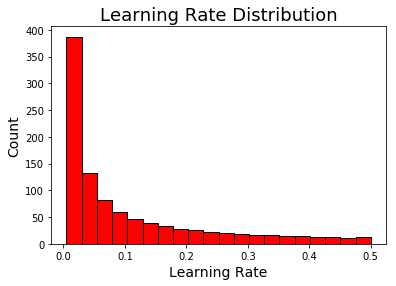

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Learning rate histogram
plt.hist(param_grid['learning_rate'], bins = 20, color = 'r', edgecolor = 'k');
plt.xlabel('Learning Rate', size = 14); plt.ylabel('Count', size = 14); plt.title('Learning Rate Distribution', size = 18);

### Thuật toán để lựa chọn những giá trị tiếp theo


Tìm kiếm theo lưới: nhập miền giá trị và thuật toán chọn giá trị tiếp theo cho mỗi siêu tham số theo một trình tự nhất định và mọi sự kết hợp trong luối đều phải được thử 1 và chỉ 1 lần.

Tìm kiếm ngẫu nhiên: nhập miền giá trị và thuật toán sẽ lựa chọn ngẫu nhiên giá trị của các siêu tham số để thử.

### Lịch sử kết quả

Xây dựng cấu trúc dữ liệu để lưu trữ lịch sử của các kết quả thực hiện. Từ đó tìm ra được giá trị tốt nhất.

In [ ]:
# Dataframes for random and grid search
random_results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(MAX_EVALS)))

grid_results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(MAX_EVALS)))

## Tìm kiếm theo lưới (Grid search)



Tìm kiếm theo lưới là thuật toán sẽ thử tất cả các kết hợp của giá trị trong miền và hy vọng tìm ra được các siêu tham số cho số điểm cao nhất và các giá trị của chúng. 

Nó gặp một vấn đề là tốn rất nhiều chi phí tính toán. Dưới đây là số lượng sự kết hợp cần phải thực hiện.

In [ ]:
com = 1
for x in param_grid.values():
    com *= len(x)
print('There are {} combinations'.format(com))

There are 2620800000000000 combinations


Giả sử 100s cho mỗi sự kết hợp:

In [ ]:
print('This would take {:.0f} years to finish.'.format((100 * com) / (60 * 60 * 24 * 365)))

This would take 8310502283 years to finish.


Dưới đây là hàm thuật toán tìm kiếm theo lưới. Đầu tiên, ta [giải nén các giá trị](https://www.geeksforgeeks.org/packing-and-unpacking-arguments-in-python/) trong lưới siêu tham số `keys, values = zip(*param_grid.items())`. Ta sẽ duyệt qua tất các các kết hợp có hoạt động.  Với mỗi vòng lặp, ta tạo một từ điển `hyperparameters = dict(zip(keys, v))` và gửi đến hàm mục tiêu được tạo trước đó. Hàm mục tiêu trả về điểm xác thực chéo từ các siêu tham số lưu dưới dạng dataframe. Sử dụng `itertools.product` (from [this Stack Overflow Question and Answer](https://codereview.stackexchange.com/questions/171173/list-all-possible-permutations-from-a-python-dictionary-of-lists)) để tạo một [generator](http://book.pythontips.com/en/latest/generators.html) thay vì lưu trữ toán bộ kết hợp có thể để tránh quá lớn về mặt lưu trữ.

Để theo dõi kết quả, tác giả đã ghi lại vào một file csv. Không được mở file này bằng excel vì nó sẽ làm file bị lỗi.

Kết quả sẽ được ghi đè vào out_file.

In [ ]:
# MAX_EVALS = 5
import itertools
import csv

# Create file and open connection
out_file = 'grid_search_trials.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write column names
headers = ['score', 'hyperparameters', 'iteration']
writer.writerow(headers)
of_connection.close()


def grid_search(param_grid, out_file, max_evals = MAX_EVALS):
    """Grid search algorithm (with limit on max evals)
       Writes result of search to csv file every search iteration."""
    
    # Dataframe to store results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(MAX_EVALS)))
    
    # https://codereview.stackexchange.com/questions/171173/list-all-possible-permutations-from-a-python-dictionary-of-lists
    keys, values = zip(*param_grid.items())
    
    i = 0
    
    # Iterate through every possible combination of hyperparameters
    for v in itertools.product(*values):
        # Select the hyperparameters
        parameters = dict(zip(keys, v))
        
        # Set the subsample ratio accounting for boosting type
        parameters['subsample'] = 1.0 if parameters['boosting_type'] == 'goss' else parameters['subsample']
        
        # Evalute the hyperparameters
        eval_results = objective(parameters, i)
        
        results.loc[i, :] = eval_results
        
        i += 1
        
        # open connection (append option) and write results
        of_connection = open(out_file, 'a')
        writer = csv.writer(of_connection)
        writer.writerow(eval_results)
        
        # make sure to close connection
        of_connection.close()
        
        # Normally would not limit iterations
        if i > MAX_EVALS:
            break
       
    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)
    
    return results    

Thông thường, số lần lặp sẽ không được giới hạn. Nó là tổng số lần kết hợp của lưới siêu tham số. Cho nên những dòng này không được dùng trong thực tế.

```
        if i > MAX_EVALS:
            break
```


Ta tiến hành thực hiện trước với 5 lần lặp để theo dõi kết quả.

In [ ]:
grid_results = grid_search(param_grid, out_file)

print('The best validation score was {:.5f}'.format(grid_results.loc[0, 'score']))
print('\nThe best hyperparameters were:')

import pprint
pprint.pprint(grid_results.loc[0, 'params'])

The best validation score was 0.71957

The best hyperparameters were:
{'boosting_type': 'gbdt',
 'colsample_bytree': 0.6,
 'is_unbalance': True,
 'learning_rate': 0.004999999999999999,
 'metric': 'auc',
 'min_child_samples': 20,
 'n_estimators': 132,
 'num_leaves': 20,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 0.5,
 'subsample_for_bin': 20000,
 'verbose': 1}


Từ các kết quả trên ta tiến hành tính toán trên tập "test" của ví dụ này.

In [ ]:
# Get the best parameters
grid_search_params = grid_results.loc[0, 'params']

# Create, train, test model
model = lgb.LGBMClassifier(**grid_search_params, random_state=42)
model.fit(train_features, train_labels)

preds = model.predict_proba(test_features)[:, 1]

print('The best model from grid search scores {:.5f} ROC AUC on the test set.'.format(roc_auc_score(test_labels, preds)))

The best model from grid search scores 0.72694 ROC AUC on the test set.


Ta xem tiến trình của các siêu tham số đã được đánh giá.

In [ ]:
pd.options.display.max_colwidth = 1000
grid_results['params'].values

array([{'boosting_type': 'gbdt', 'num_leaves': 20, 'learning_rate': 0.004999999999999999, 'subsample_for_bin': 20000, 'min_child_samples': 20, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'colsample_bytree': 0.6, 'subsample': 0.5, 'is_unbalance': True, 'metric': 'auc', 'verbose': 1, 'n_estimators': 132},
       {'boosting_type': 'gbdt', 'num_leaves': 20, 'learning_rate': 0.004999999999999999, 'subsample_for_bin': 20000, 'min_child_samples': 20, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'colsample_bytree': 0.6, 'subsample': 0.5, 'is_unbalance': False, 'metric': 'auc', 'verbose': 1, 'n_estimators': 132},
       {'boosting_type': 'gbdt', 'num_leaves': 20, 'learning_rate': 0.004999999999999999, 'subsample_for_bin': 20000, 'min_child_samples': 20, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'colsample_bytree': 0.6, 'subsample': 0.5050505050505051, 'is_unbalance': True, 'metric': 'auc', 'verbose': 1, 'n_estimators': 132},
       {'boosting_type': 'gbdt', 'num_leaves': 20, 'learning_rate': 0.004999999999999999, 

Ta thấy chỉ có `subsample` và `is_unbalance` thay đổi. Đây là vấn đề của grid search vì dù sự thay đổi có nhỏ đến mức nào thì nó vấn thực hiện thử tất cả. Mà khi sự thay đổi quá nhỏ thì validation score sẽ chưa đủ để thay đổi. Do đó ta cần tìm giải pháp tốt hơn và không nên thử trên toàn bộ tập dữ liệu.

## Tìm kiếm ngẫu nhiên (Random Search)

Tìm kiếm ngẫu nhiên đạt được kết quả tốt hơn so với tìm kiếm theo lưới bởi vì nó tìm được giá trị đủ gần với số lần lặp ít hơn nhiều. Thêm một lý do là tìm kiếm ngẫu nhiên kiểm soát không gian tốt hơn cho nên nó đỡ mất thời gian nhưng vẫn tìm được giá trị tốt.

Tìm kiếm ngẫu nhiên sẽ được thực hiện bằng cách chọn ngẫu nhiên các bộ siêu tham số tiếp theo từ lưới.

In [ ]:
random.seed(50)

# Randomly sample from dictionary
random_params = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}
# Deal with subsample ratio
random_params['subsample'] = 1.0 if random_params['boosting_type'] == 'goss' else random_params['subsample']

random_params

{'boosting_type': 'goss',
 'colsample_bytree': 0.8222222222222222,
 'is_unbalance': False,
 'learning_rate': 0.027778881111994384,
 'min_child_samples': 175,
 'num_leaves': 88,
 'reg_alpha': 0.8979591836734693,
 'reg_lambda': 0.6122448979591836,
 'subsample': 1.0,
 'subsample_for_bin': 220000}

Hàm `random_search` tương tự với `grid_search` tuy nhiên nó sẽ khác ở phương pháp tìm kiếm siêu tham số tiếp theo và nó sẽ có giới hạn số lần lặp lại.

In [ ]:
# Create file and open connection
out_file = 'random_search_trials.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write column names
headers = ['score', 'hyperparameters', 'iteration']
writer.writerow(headers)
of_connection.close()

def random_search(param_grid, out_file, max_evals = MAX_EVALS):
    """Random search for hyperparameter optimization. 
       Writes result of search to csv file every search iteration."""
    
    
    # Dataframe for results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                                  index = list(range(MAX_EVALS)))
    for i in range(MAX_EVALS):
        
        # Choose random hyperparameters
        random_params = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}
        random_params['subsample'] = 1.0 if random_params['boosting_type'] == 'goss' else random_params['subsample']

        # Evaluate randomly selected hyperparameters
        eval_results = objective(random_params, i)
        results.loc[i, :] = eval_results

        # open connection (append option) and write results
        of_connection = open(out_file, 'a')
        writer = csv.writer(of_connection)
        writer.writerow(eval_results)
        
        # make sure to close connection
        of_connection.close()
        
    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)

    return results 

In [ ]:
random_results = random_search(param_grid, out_file)

print('The best validation score was {:.5f}'.format(random_results.loc[0, 'score']))
print('\nThe best hyperparameters were:')

import pprint
pprint.pprint(random_results.loc[0, 'params'])

The best validation score was 0.72420

The best hyperparameters were:
{'boosting_type': 'dart',
 'colsample_bytree': 0.9555555555555555,
 'is_unbalance': True,
 'learning_rate': 0.2797162853084688,
 'metric': 'auc',
 'min_child_samples': 365,
 'n_estimators': 16,
 'num_leaves': 50,
 'reg_alpha': 0.6326530612244897,
 'reg_lambda': 0.5510204081632653,
 'subsample': 0.8434343434343434,
 'subsample_for_bin': 220000,
 'verbose': 1}


In [ ]:
# Get the best parameters
random_search_params = random_results.loc[0, 'params']

# Create, train, test model
model = lgb.LGBMClassifier(**random_search_params, random_state = 42)
model.fit(train_features, train_labels)

preds = model.predict_proba(test_features)[:, 1]

print('The best model from random search scores {:.5f} ROC AUC on the test set.'.format(roc_auc_score(test_labels, preds)))

The best model from random search scores 0.71347 ROC AUC on the test set.


Ta xem sự thay đổi của các siêu tham số.

In [ ]:
random_results['params']

0        {'boosting_type': 'dart', 'num_leaves': 50, 'learning_rate': 0.2797162853084688, 'subsample_for_bin': 220000, 'min_child_samples': 365, 'reg_alpha': 0.6326530612244897, 'reg_lambda': 0.5510204081632653, 'colsample_bytree': 0.9555555555555555, 'subsample': 0.8434343434343434, 'is_unbalance': True, 'metric': 'auc', 'verbose': 1, 'n_estimators': 16}
1     {'boosting_type': 'gbdt', 'num_leaves': 104, 'learning_rate': 0.08633904519421778, 'subsample_for_bin': 200000, 'min_child_samples': 290, 'reg_alpha': 0.8163265306122448, 'reg_lambda': 0.1020408163265306, 'colsample_bytree': 0.6444444444444444, 'subsample': 0.9444444444444444, 'is_unbalance': False, 'metric': 'auc', 'verbose': 1, 'n_estimators': 41}
2    {'boosting_type': 'dart', 'num_leaves': 130, 'learning_rate': 0.005116582891651224, 'subsample_for_bin': 80000, 'min_child_samples': 235, 'reg_alpha': 0.3469387755102041, 'reg_lambda': 0.5510204081632653, 'colsample_bytree': 0.6444444444444444, 'subsample': 0.6262626262626263, '

Ta có thể thấy siêu tham số xuất hiện rất ngẫu nhiên. Nếu ta có giới hạn thời gian, thì đây thực sự là một cách tốt.

## Thực hiện tìm kiếm trên tập Limited Data

Tập Limited Data là tập gồm 16000 mẫu ta đã chia từ đầu. Tác giả thực hiện trước trên tập này, vì tập toàn bộ có tới ~300.000 mẫu. Ta sẽ tìm kiếm trên 1000 vòng lặp để so sánh kết quả. Không thực hiện grid search trên toàn bộ vòng lặp vì thời gian sẽ rất lâu (đã đề cập ở trên).

Chạy những dòng code này để thực hiện trên tập dữ liệu giới hạn.
Nhóm đã thực hiện trước và lưu lại file các file csv vào dataset "Home Credit Team8 Model Tuning" nên đoạn code dưới này được comment lại.

In [ ]:
# MAX_EVALS = 1000

# # Create file and open connection
# out_file = 'grid_search_trials_1000.csv'
# of_connection = open(out_file, 'w')
# writer = csv.writer(of_connection)

# # Write column names
# headers = ['score', 'hyperparameters', 'iteration']
# writer.writerow(headers)
# of_connection.close()

# grid_results = grid_search(param_grid, out_file)


# # Create file and open connection
# out_file = 'random_search_trials_1000.csv'
# of_connection = open(out_file, 'w')
# writer = csv.writer(of_connection)

# # Write column names
# headers = ['score', 'hyperparameters', 'iteration']
# writer.writerow(headers)
# of_connection.close()

# random_results = random_search(param_grid, out_file)

# Kết quả trên tập Limited Data


Kết quả này thực hiện trên 1000 vòng lặp.

In [ ]:
random_results = pd.read_csv('../input/home-credit-team8-model-tuning/random_search_trials_1000.csv').sort_values('score', ascending = False).reset_index()
grid_results = pd.read_csv('../input/home-credit-team8-model-tuning/grid_search_trials_1000.csv').sort_values('score', ascending = False).reset_index()

Khi lưu về file csv dữ liệu bị lưu ở dạng string. Do đó dùng `ast.literal_eval` để chuyển lại về dạng từ điển.

In [ ]:
import ast

# Convert strings to dictionaries
grid_results['hyperparameters'] = grid_results['hyperparameters'].map(ast.literal_eval)
random_results['hyperparameters'] = random_results['hyperparameters'].map(ast.literal_eval)

Sau đây là hàm phân tích kết quả từ các tìm kiếm. Hàm trả về một dataframe với mỗi cột là một siêu tham số và mỗi hàng có một kết quả tìm kiếm.

In [ ]:
def evaluate(results, name):
    """Evaluate model on test data using hyperparameters in results
       Return dataframe of hyperparameters"""
        
    # Sort with best values on top
    results = results.sort_values('score', ascending = False).reset_index(drop = True)
    
    # Print out cross validation high score
    print('The highest cross validation score from {} was {:.5f} found on iteration {}.'.format(name, results.loc[0, 'score'], results.loc[0, 'iteration']))
    
    # Use best hyperparameters to create a model
    hyperparameters = results.loc[0, 'hyperparameters']
    model = lgb.LGBMClassifier(**hyperparameters)
    
    # Train and make predictions
    model.fit(train_features, train_labels)
    preds = model.predict_proba(test_features)[:, 1]
    
    print('ROC AUC from {} on test data = {:.5f}.'.format(name, roc_auc_score(test_labels, preds)))
    
    # Create dataframe of hyperparameters
    hyp_df = pd.DataFrame(columns = list(results.loc[0, 'hyperparameters'].keys()))

    # Iterate through each set of hyperparameters that were evaluated
    for i, hyp in enumerate(results['hyperparameters']):
        hyp_df = hyp_df.append(pd.DataFrame(hyp, index = [0]), 
                               ignore_index = True)
        
    # Put the iteration and score in the hyperparameter dataframe
    hyp_df['iteration'] = results['iteration']
    hyp_df['score'] = results['score']
    
    return hyp_df

In [ ]:
grid_hyp = evaluate(grid_results, name = 'grid search')

The highest cross validation score from grid search was 0.72112 found on iteration 801.
ROC AUC from grid search on test data = 0.74137.


In [ ]:
random_hyp = evaluate(random_results, name = 'random search')

The highest cross validation score from random search was 0.72986 found on iteration 474.
ROC AUC from random search on test data = 0.73985.


# Visualizations

Tác giả sử dụng matplotlib, seaborn để trực quán hoá giúp chúng ta có cái nhìn trực quan hơn.

### Biểu đồ thể hiện độ đo ROC AUC qua mỗi lần lặp

Biểu đồ được vẽ bằng seaborn.

In [ ]:
best_grid_hyp = grid_hyp.iloc[grid_hyp['score'].idxmax()].copy()
best_random_hyp = random_hyp.iloc[random_hyp['score'].idxmax()].copy()

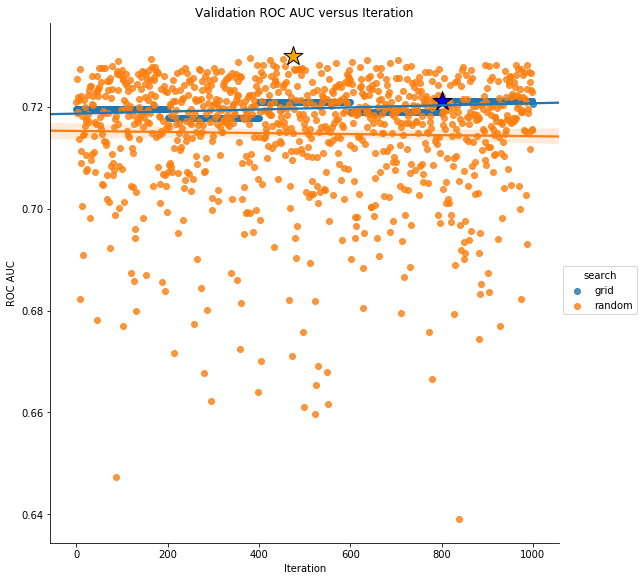

In [ ]:
# Combine results into one dataframe
random_hyp['search'] = 'random'
grid_hyp['search'] = 'grid'

hyp = random_hyp.append(grid_hyp)
hyp.head()
hyp.sort_values('search', inplace = True)

# Plot of scores over the course of searching
sns.lmplot('iteration', 'score', hue = 'search', data = hyp, size = 8);
plt.scatter(best_grid_hyp['iteration'], best_grid_hyp['score'], marker = '*', s = 400, c = 'blue', edgecolor = 'k')
plt.scatter(best_random_hyp['iteration'], best_random_hyp['score'], marker = '*', s = 400, c = 'orange', edgecolor = 'k')
plt.xlabel('Iteration'); plt.ylabel('ROC AUC'); plt.title("Validation ROC AUC versus Iteration");

In [ ]:
print('Average validation score of grid search =   {:.5f}.'.format(np.mean(grid_hyp['score'])))
print('Average validation score of random search = {:.5f}.'.format(np.mean(random_hyp['score'])))

Average validation score of grid search =   0.71964.
Average validation score of random search = 0.71471.


Grid cross validation score tăng lên theo thời gian và nó bị bó buộc trong một phạm vi, do đó nó không thể tiến tới thực hiện những siêu tham số có giá trị tốt. Ngược lại, random cross validation scores thực hiện rất tốt việc thử các giá trị ngẫu nhiên và đạt được những kết quả cao.

## Chuỗi các kết quả tìm kiếm

Biểu đồ chuỗi các giá trị tìm kiếm với mỗi lần lặp của random search. Ngôi sao thể hiện kết quả tốt nhất.

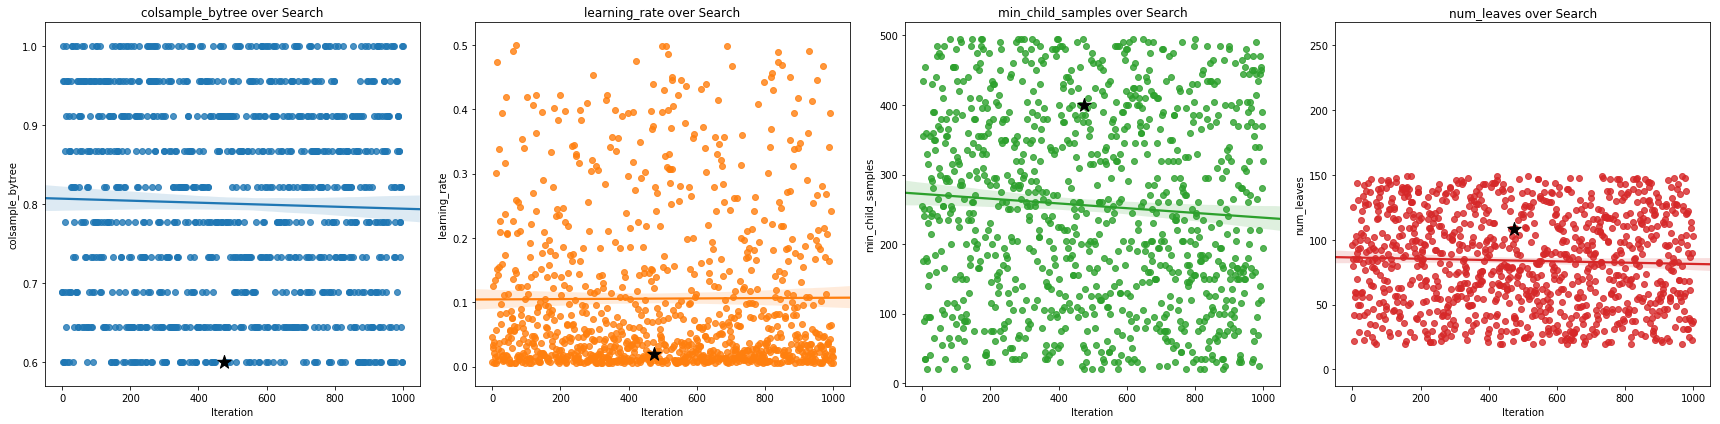

In [ ]:
fig, axs = plt.subplots(1, 4, figsize = (24, 6))
i = 0

# Plot of four hyperparameters
for i, hyper in enumerate(['colsample_bytree', 'learning_rate', 'min_child_samples', 'num_leaves']):
        random_hyp[hyper] = random_hyp[hyper].astype(float)
        # Scatterplot
        sns.regplot('iteration', hyper, data = random_hyp, ax = axs[i])
        axs[i].scatter(best_random_hyp['iteration'], best_random_hyp[hyper], marker = '*', s = 200, c = 'k')
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hyper), title = '{} over Search'.format(hyper));

plt.tight_layout()

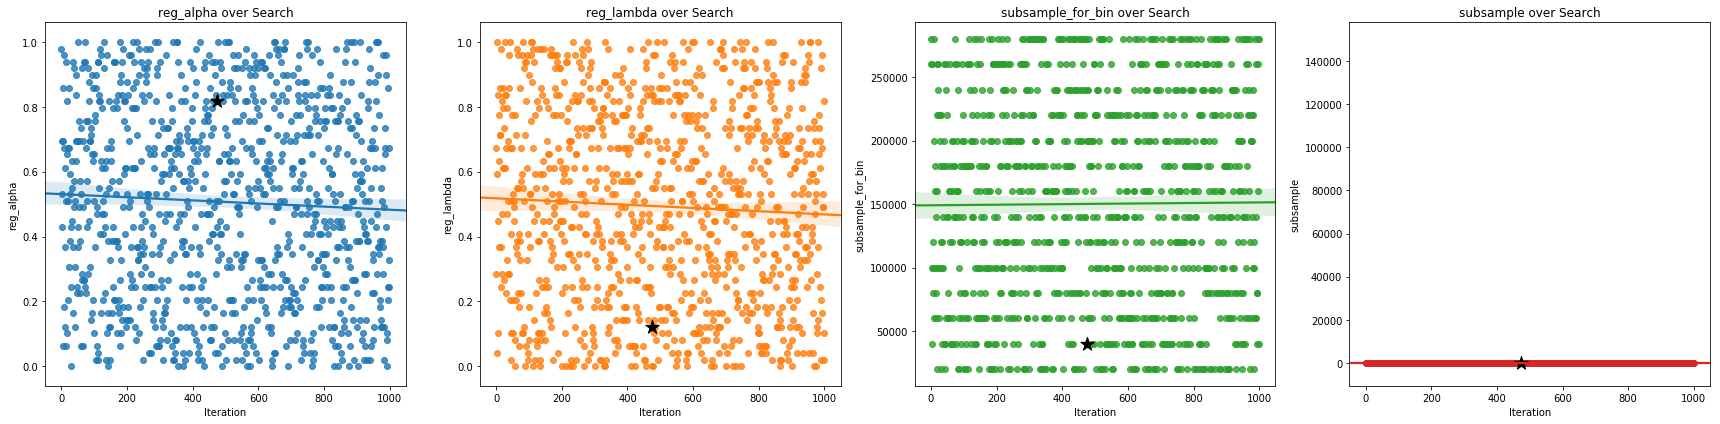

In [ ]:
fig, axs = plt.subplots(1, 4, figsize = (24, 6))
i = 0

# Scatterplot of next four hyperparameters
for i, hyper in enumerate(['reg_alpha', 'reg_lambda', 'subsample_for_bin', 'subsample']):
        random_hyp[hyper] = random_hyp[hyper].astype(float)
        sns.regplot('iteration', hyper, data = random_hyp, ax = axs[i])
        axs[i].scatter(best_random_hyp['iteration'], best_random_hyp[hyper], marker = '*', s = 200, c = 'k')
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hyper), title = '{} over Search'.format(hyper));

plt.tight_layout()

## Mối tương quan Score với Hyperparameters

Biểu đồ thể hiện sự tương quan giữa điểm số và các giá trị của các siêu tham số.

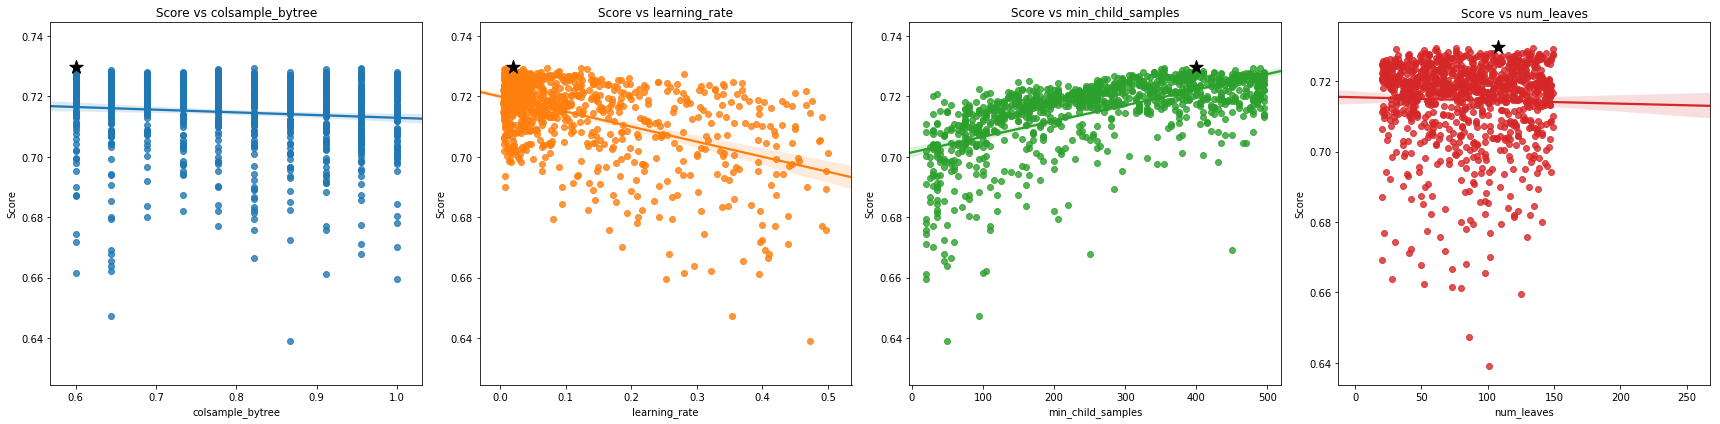

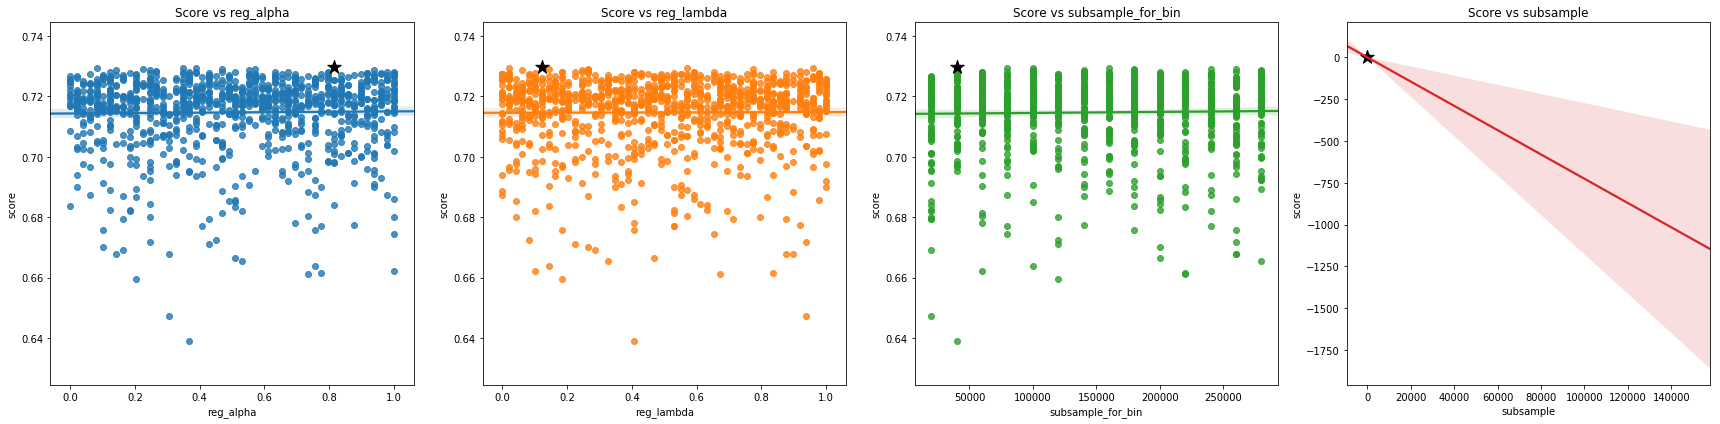

In [ ]:
fig, axs = plt.subplots(1, 4, figsize = (24, 6))
i = 0

# Plot of four hyperparameters
for i, hyper in enumerate(['colsample_bytree', 'learning_rate', 'min_child_samples', 'num_leaves']):
        random_hyp[hyper] = random_hyp[hyper].astype(float)
        # Scatterplot
        sns.regplot(hyper, 'score', data = random_hyp, ax = axs[i])
        axs[i].scatter(best_random_hyp[hyper], best_random_hyp['score'], marker = '*', s = 200, c = 'k')
        axs[i].set(xlabel = '{}'.format(hyper), ylabel = 'Score', title = 'Score vs {}'.format(hyper));

plt.tight_layout()

fig, axs = plt.subplots(1, 4, figsize = (24, 6))
i = 0

# Scatterplot of next four hyperparameters
for i, hyper in enumerate(['reg_alpha', 'reg_lambda', 'subsample_for_bin', 'subsample']):
        random_hyp[hyper] = random_hyp[hyper].astype(float)
        sns.regplot(hyper, 'score', data = random_hyp, ax = axs[i])
        axs[i].scatter(best_random_hyp[hyper], best_random_hyp['score'], marker = '*', s = 200, c = 'k')
        axs[i].set(xlabel = '{}'.format(hyper), ylabel = 'score', title = 'Score vs {}'.format(hyper));

plt.tight_layout()

Các biểu đồ trên không có thực sự quá ý nghĩa, vì tại một thời điểm ta không thay đổi một siêu tham số mà kết hợp nhiều siêu tham số với nhau.

# Kiểm thử trên toàn bộ tập dữ liệu

Sử dụng các siêu tham số tốt nhất được tìm ra từ random search để áp dụng cho toàn bộ tập dữ liệu.

In [ ]:
# Read in full dataset
train = pd.read_csv('../input/home-credit-team8-dataset3/final_train_3.csv')
test = pd.read_csv('../input/home-credit-team8-dataset3/final_test_3.csv')

# Extract the test ids and train labels
test_ids = test['SK_ID_CURR']
train_labels = np.array(train['TARGET'].astype(np.int32)).reshape((-1, ))

train = train.drop(columns = ['SK_ID_CURR', 'TARGET'])
test = test.drop(columns = ['SK_ID_CURR'])

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (307511, 416)
Testing shape:  (48744, 416)


Đầu tiên ta sẽ tiến hành xác thực chéo dựa trên các giá trị siêu tham số có được từ random search. Ở đây ta sẽ sử dụng early stopping để tìm ra số lượng cây quyết định để huấn luyện

In [ ]:
train_set = lgb.Dataset(train, label = train_labels)

hyperparameters = dict(**random_results.loc[0, 'hyperparameters'])
del hyperparameters['n_estimators']

# Cross validation with n_folds and early stopping
cv_results = lgb.cv(hyperparameters, train_set,
                    num_boost_round = 10000, early_stopping_rounds = 100, 
                    metrics = 'auc', nfold = N_FOLDS)

In [ ]:
print('The cross validation score on the full dataset = {:.5f} with std: {:.5f}.'.format(
    cv_results['auc-mean'][-1], cv_results['auc-stdv'][-1]))
print('Number of estimators = {}.'.format(len(cv_results['auc-mean'])))

The cross validation score on the full dataset = 0.78518 with std: 0.00270.
Number of estimators = 774.


Tiếp theo là dự đoán kết quả:

In [ ]:
# Train the model with the optimal number of estimators from early stopping
model = lgb.LGBMClassifier(n_estimators = len(cv_results['auc-mean']), **hyperparameters)
model.fit(train, train_labels)
                        
# Predictions on the test data
preds = model.predict_proba(test)[:, 1]

In [ ]:
submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': preds})
submission.to_csv('submission_simple_features_random.csv', index = False)

Điểm số khi submit là:
- Public Leaderboard: __0.78756__.
- Private Leaderboard: __0.79168__.

# Nhận xét

## Ưu nhược điểm của 2 phương pháp:

1. Grid Search:
- (+) Có thể đi hết các trường hợp của bộ siêu tham số
- (-) Tốn rất nhiều thời gian và chi phí tính toán
2. Random Search:
- (+) Tiết kiệm thời gian, với 1 giới hạn thời gian và chi phí thì có thể cho kết quả tốt hơn Grid Search
- (-) Không đi hết được các trường hợp, kết quả cuối có thể chưa phải là tốt nhất

## Kết hợp Random and Grid Search


1. Sử dụng random search với một lưới siêu tham số lớn
2. Sử dụng kết quả của random search để xây dựng một lưới tập trung xung quanh những siêu tham số có giá trị tốt.
3. Chạy grid search trên lưới mới này.
4. Lặp lại grid search trên các lưới tập trung khác cho đến khi đạt giới hạn.

Nhóm sẽ tham khảo thêm cách thực hiện bằng phương pháp [sau](https://scikit-optimize.github.io/stable/).